Preparation

In [ ]:
#Preparation
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.0.0+cu118
2.0.1+cu118
cpu


In [ ]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
SPEECH_FILE = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")

IPython.display.Audio(SPEECH_FILE)

Creating a pipeline

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_10M
acoustic_model = bundle.get_model()
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


Loading data

In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
print(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

cpu


Extracting acoustic features

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

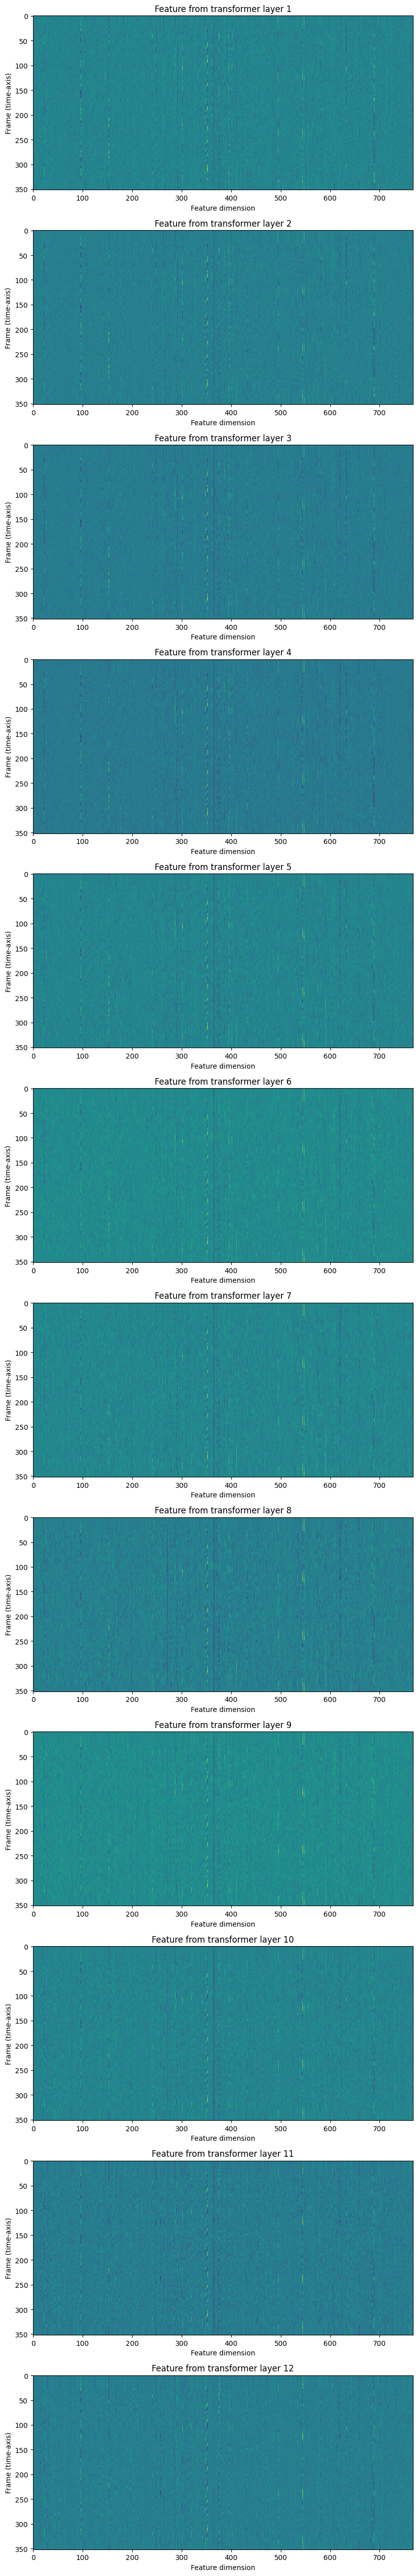

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

Feature classification

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

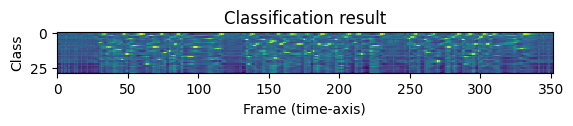

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

Generating transcripts

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|REILY|WAS|VERY|MUCH|AFFRAYD|OF|SHOWING|HIM|HOWMUCH|SHOKTD|I|WAUSE|AT|SOME|PARTE|OF|WHAT|HE|SEID|


Tokens

In [ ]:
tokens = [label.lower() for label in bundle.get_labels()]
print(tokens)

['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm', 'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']


Language model

In [ ]:
from torchaudio.models.decoder import CTCDecoderLM, CTCDecoderLMState

class CustomLM(CTCDecoderLM):
    """Create a Python wrapper around `language_model` to feed to the decoder."""
    def __init__(self, language_model: torch.nn.Module):
        CTCDecoderLM.__init__(self)
        self.language_model = language_model
        self.sil = -1  # index for silent token in the language model
        self.states = {}

        language_model.eval()

    def start(self, start_with_nothing: bool = False):
        state = CTCDecoderLMState()
        with torch.no_grad():
            score = self.language_model(self.sil)

        self.states[state] = score
        return state

    def score(self, state: CTCDecoderLMState, token_index: int):
        outstate = state.child(token_index)
        if outstate not in self.states:
            score = self.language_model(token_index)
            self.states[outstate] = score
        score = self.states[outstate]

        return outstate, score

    def finish(self, state: CTCDecoderLMState):
        return self.score(state, self.sil)

/usr/local/lib/python3.10/dist-packages/torchaudio/models/decoder/_ctc_decoder.py:62: UserWarning: The built-in flashlight integration is deprecated, and will be removed in future release. Please install flashlight-text. https://pypi.org/project/flashlight-text/ For the detail of CTC decoder migration, please see https://github.com/pytorch/audio/issues/3088.
  warnings.warn(


In [ ]:
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

print(files)

PretrainedFiles(lexicon='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


Beam Search Decoder

In [ ]:
from torchaudio.models.decoder import ctc_decoder
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

Greedy Decoder

In [ ]:
from typing import List
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("|", " ").strip().split()


greedy_decoder = GreedyCTCDecoder(tokens)

Run Inference

In [ ]:
actual_transcript = "i really was very much afraid of showing him how much shocked i was at some part of what he said"
actual_transcript = actual_transcript.split()

In [ ]:
greedy_result = greedy_decoder(emission[0])
greedy_transcript = " ".join(greedy_result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)

print(f"Transcript: {greedy_transcript}")
print(f"WER: {greedy_wer}")


Transcript: i reily was very much affrayd of showing him howmuch shoktd i wause at some parte of what he seid
WER: 0.38095238095238093


In [ ]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"Transcript: {beam_search_transcript}")
print(f"WER: {beam_search_wer}")

Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.0


Timestep Alignments

In [ ]:
timesteps = beam_search_result[0][0].timesteps
predicted_tokens = beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens)

print(predicted_tokens, len(predicted_tokens))
print(timesteps, timesteps.shape[0])

['|', 'i', '|', 'r', 'e', 'a', 'l', 'l', 'y', '|', 'w', 'a', 's', '|', 'v', 'e', 'r', 'y', '|', 'm', 'u', 'c', 'h', '|', 'a', 'f', 'r', 'a', 'i', 'd', '|', 'o', 'f', '|', 's', 'h', 'o', 'w', 'i', 'n', 'g', '|', 'h', 'i', 'm', '|', 'h', 'o', 'w', '|', 'm', 'u', 'c', 'h', '|', 's', 'h', 'o', 'c', 'k', 'e', 'd', '|', 'i', '|', 'w', 'a', 's', '|', 'a', 't', '|', 's', 'o', 'm', 'e', '|', 'p', 'a', 'r', 't', '|', 'o', 'f', '|', 'w', 'h', 'a', 't', '|', 'h', 'e', '|', 's', 'a', 'i', 'd', '|', '|'] 99
tensor([  0,  31,  33,  36,  39,  41,  42,  44,  46,  48,  49,  52,  54,  58,
         64,  66,  69,  73,  74,  76,  80,  82,  84,  86,  88,  94,  97, 107,
        111, 112, 116, 134, 136, 138, 140, 142, 146, 148, 151, 153, 155, 157,
        159, 161, 162, 166, 170, 176, 177, 178, 179, 182, 184, 186, 187, 191,
        193, 198, 201, 202, 203, 205, 207, 212, 213, 216, 222, 224, 230, 250,
        251, 254, 256, 261, 262, 264, 267, 270, 276, 277, 281, 284, 288, 289,
        292, 295, 297, 299, 300, 

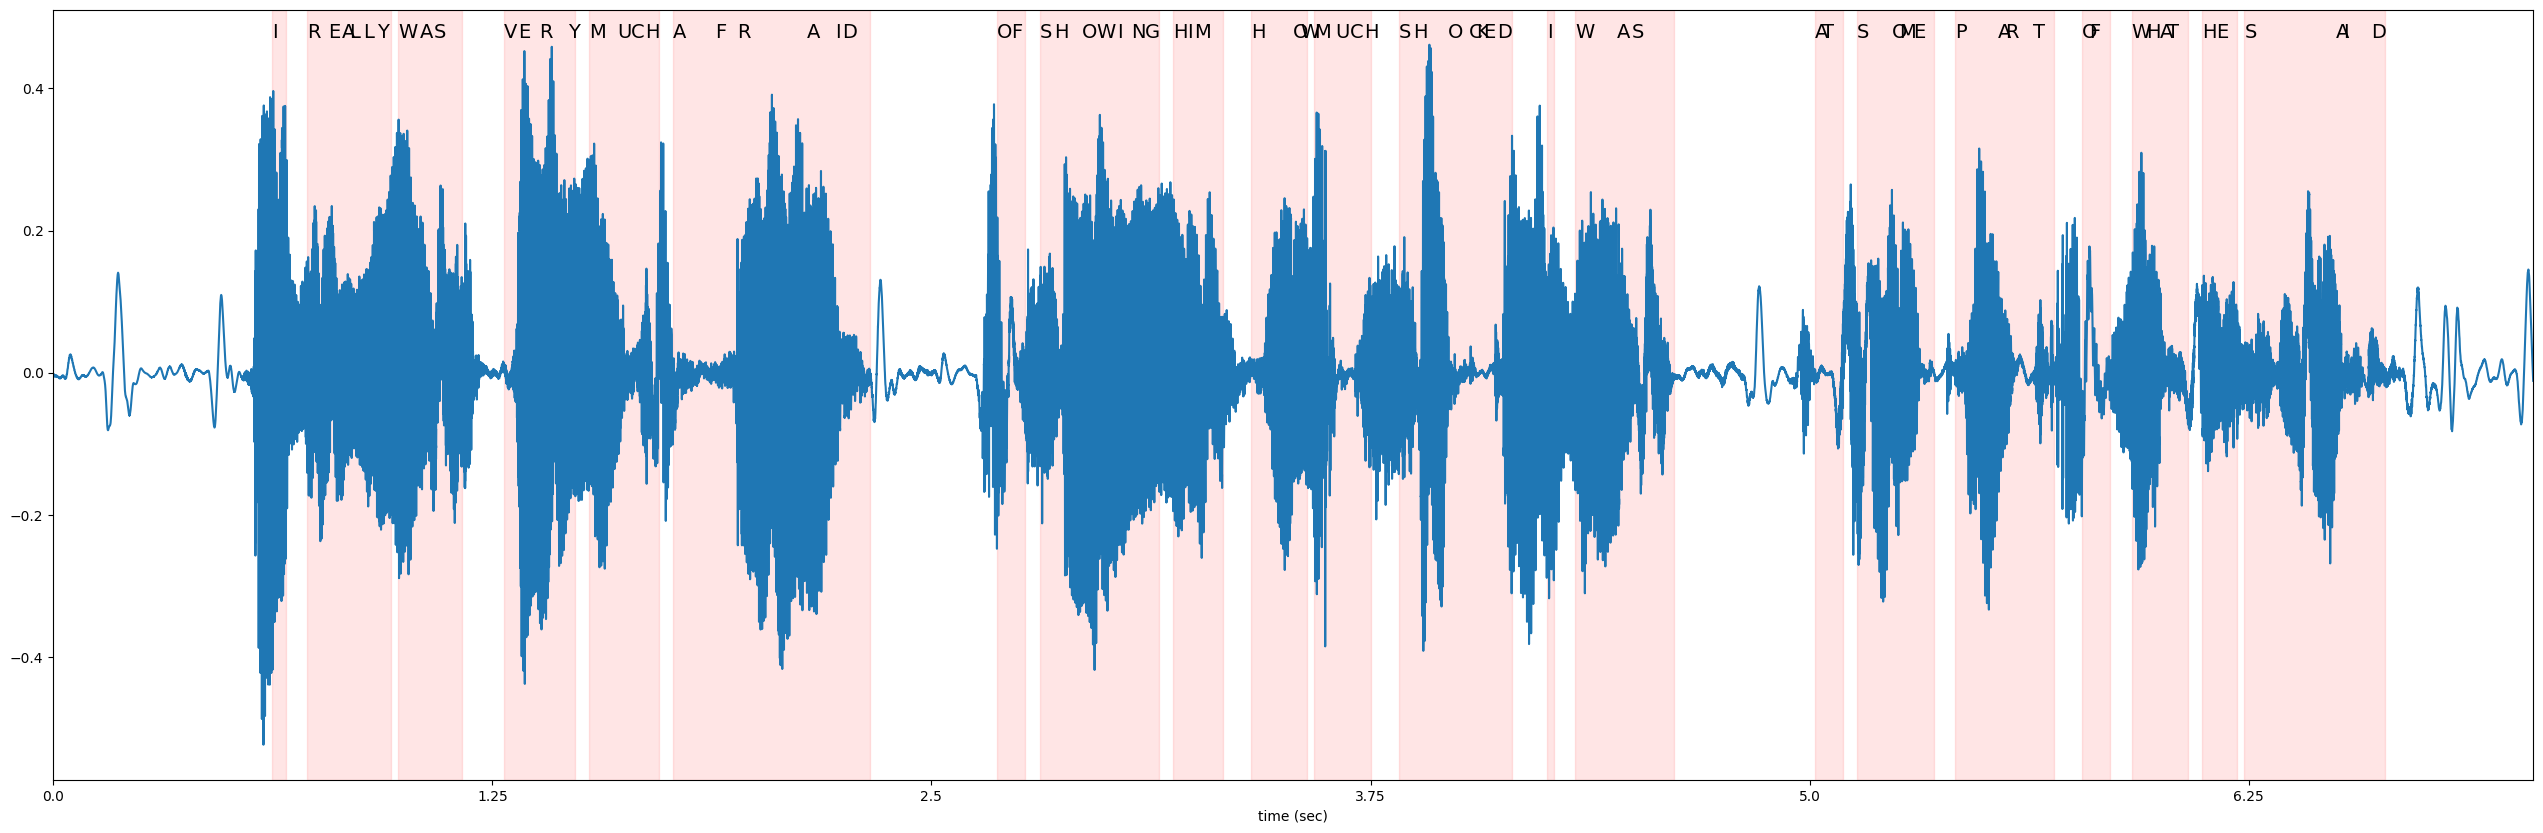

In [ ]:
def plot_alignments(waveform, emission, tokens, timesteps):
    fig, ax = plt.subplots(figsize=(32, 10))

    ax.plot(waveform)

    ratio = waveform.shape[0] / emission.shape[1]
    word_start = 0

    for i in range(len(tokens)):
        if i != 0 and tokens[i - 1] == "|":
            word_start = timesteps[i]
        if tokens[i] != "|":
            plt.annotate(tokens[i].upper(), (timesteps[i] * ratio, waveform.max() * 1.02), size=14)
        elif i != 0:
            word_end = timesteps[i]
            ax.axvspan(word_start * ratio, word_end * ratio, alpha=0.1, color="red")

    xticks = ax.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax.set_xlabel("time (sec)")
    ax.set_xlim(0, waveform.shape[0])


plot_alignments(waveform[0], emission, predicted_tokens, timesteps)

Beam Search Decoder Parameters

In [ ]:
#Helper Function
def print_decoded(decoder, emission, param, param_value):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    score = result[0][0].score
    print(f"{param} {param_value:<3}: {transcript} (score: {score:.2f}; {decode_time:.4f} secs)")

In [ ]:
#nbest
for i in range(3):
    transcript = " ".join(beam_search_result[0][i].words).strip()
    score = beam_search_result[0][i].score
    print(f"{transcript} (score: {score})")

i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.823839395043)
i really was very much afraid of showing him how much shocked i was at some parts of what he said (score: 3697.858107255694)
i reply was very much afraid of showing him how much shocked i was at some part of what he said (score: 3695.015488207337)


In [ ]:
#beam size
import time
beam_sizes = [1, 5, 50, 500]

for beam_size in beam_sizes:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_size=beam_size,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam size", beam_size)

beam size 1  : i you ery much afra of shongut shot i was at some arte what he sad (score: 3144.93; 0.0766 secs)
beam size 5  : i rely was very much afraid of showing him how much shot i was at some parts of what he said (score: 3688.02; 0.1205 secs)
beam size 50 : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 1.7551 secs)
beam size 500: i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 2.5780 secs)


In [ ]:
#beam size token
num_tokens = len(tokens)
beam_size_tokens = [1, 5, 10, num_tokens]

for beam_size_token in beam_size_tokens:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_size_token=beam_size_token,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam size token", beam_size_token)

beam size token 1  : i rely was very much affray of showing him hoch shot i was at some part of what he sed (score: 3584.80; 2.1645 secs)
beam size token 5  : i rely was very much afraid of showing him how much shocked i was at some part of what he said (score: 3694.83; 0.1522 secs)
beam size token 10 : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3696.25; 2.5351 secs)
beam size token 29 : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 2.3128 secs)


In [ ]:
#beam threshold
beam_thresholds = [1, 5, 10, 25]

for beam_threshold in beam_thresholds:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_threshold=beam_threshold,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam threshold", beam_threshold)

beam threshold 1  : i ila ery much afraid of shongut shot i was at some parts of what he said (score: 3316.20; 0.0954 secs)
beam threshold 5  : i rely was very much afraid of showing him how much shot i was at some parts of what he said (score: 3682.23; 0.1587 secs)
beam threshold 10 : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 2.7114 secs)
beam threshold 25 : i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 2.5863 secs)


In [ ]:
#language model weight
lm_weights = [0, LM_WEIGHT, 15]

for lm_weight in lm_weights:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        lm_weight=lm_weight,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "lm weight", lm_weight)

lm weight 0  : i rely was very much affraid of showing him ho much shoke i was at some parte of what he seid (score: 3834.05; 2.3246 secs)
lm weight 3.23: i really was very much afraid of showing him how much shocked i was at some part of what he said (score: 3699.82; 2.6081 secs)
lm weight 15 : was there in his was at some of what he said (score: 2918.98; 3.0365 secs)


Training Accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

# Set up the data loaders
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        total_correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = total_correct / len(train_loader.dataset)
    print('Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch, train_loss, total_correct, len(train_loader.dataset),
        100. * train_acc))

# Set up the device and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

# Train the model for 10 epochs
for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, epoch)

100%|██████████| 9912422/9912422 [00:00<00:00, 94974840.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73415572.01it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26808170.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9937678.02it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Average loss: 0.0034, Accuracy: 56108/60000 (93.51%)
Epoch 2: Average loss: 0.0014, Accuracy: 58419/60000 (97.36%)
Epoch 3: Average loss: 0.0011, Accuracy: 58746/60000 (97.91%)
Epoch 4: Average loss: 0.0009, Accuracy: 59007/60000 (98.34%)
Epoch 5: Average loss: 0.0008, Accuracy: 59060/60000 (98.43%)
Epoch 6: Average loss: 0.0007, Accuracy: 59184/60000 (98.64%)
Epoch 7: Average loss: 0.0007, Accuracy: 59282/60000 (98.80%)
Epoch 8: Average loss: 0.0006, Accuracy: 59310/60000 (98.85%)
Epoch 9: Average loss: 0.0006, Accuracy: 59369/60000 (98.95%)
Epoch 10: Average loss: 0.0005, Accuracy: 59453/60000 (99.09%)
